In [1]:
%matplotlib inline

# PyRates - A Python framework for rate-based neural simulations

PyRates is a software for numerical simulations of rate-based neural models. Its basic architecture is divided into a frontend for the model definition and a backend performing the actual simulations.

<img src="img/pyrates_architecture.png">

When building neural networks with PyRates, the user has to set up templates for the mathematical operators that should be employed in a model, define nodes and edges in a network based on those operators and finally bring them together to a full circuit model.
This principle is depicted in the figure below:

<img src="img/pyrates_model.png">

In the following tutorial, you will learn how to define a neural network model in pyrates, perform numerical simulations on that model, visualize the simulation results and perform parameter sweeps. Afterwards, you can apply that knowledge by filling in the gaps in the jupyter notebook `Task_Build_Cortical_Microcircuit` such that all of its cells can be executed without errors.

As a heads up - model set up and numerical simulations in PyRates can be as simple as shown in the cell below:

vectorizing the graph nodes...
building the compute graph...
Preparing the simulation...
Running the simulation...
finished!


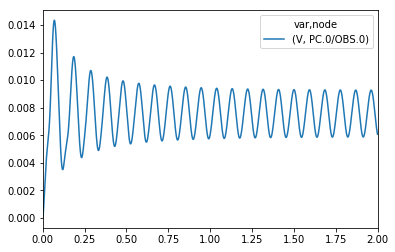

In [2]:
from pyrates.backend import ComputeGraph
import numpy as np

net = ComputeGraph("model_templates.jansen_rit.simple_jansenrit.JRC", dt=1e-4,
                   backend='numpy')
results = net.run(simulation_time=2.0, 
                  inputs={'PC.0/RPO_e_pc.0/u': np.zeros((int(2/1e-4), 1)) + 220.0},
                  outputs={'V': 'PC.0/OBS.0/V'})
results.plot()

which simulated and plotted the average membrane potential of the pyramidal cell population of a Jansen-Rit model over 2 s. In the tutorial part, we will show you how to define this model in PyRates yourself and what the different options are along the model definition.

# Tutorial: Setting up a Jansen-Rit model in PyRates

This tutorial shows you how to set up a network model according to Jansen & Rit (Biol. Cybern., 1995). This model describes the dynamic interactions between the pyramidal cells, excitatory interneurons and inhibitory interneurons in a cortical microcircuit. To this end, it uses a mass modeling approach. Its basic structure is depicted below, while the essential equations will be introduced as part of the tutorial.

<img src="img/JR_circuit_reduced.png">

In the rest of the tutorial, the following questions will be answered via the example of the Jansen-Rit model:


1. **What is a YAML template file?**
2. **How do I create a network model from a YAML template?**
3. **How do I run simulations on my network model?**
4. **How do I run parameter studies on my model?**
5. **How can I create a network model without YAML templates?**

## Part 1: What is a YAML template file?

[YAML](https://yaml.org/spec/1.2/spec.html) is a data formatting specification that aims to be human-readable and machine-readable at the same time. It's current installment can be thought of as an extension to the also popular JSON standard. 

PyRates uses YAML files to provide a simple and readable way to define network models without any Python code. 

#### Operator template for the PRO

Below you see a YAML template that defines the so-called potential-to-rate operator (PRO) used within each neural population of the Jansen-Rit model. As the name suggests, this operator transforms the average membrane potential within a population into an average firing rate. It is defined by the following instantaneous, sigmoidal function
$$m_{out} = \frac{m_{max}}{1. + \exp{(r (V_{thr} - V))}}.$$

In this equation, $m_{out}$ and $V$ represent the average firing rate and membrane potential, respectively, while $m_{max}$, $r$ and $V_{thr}$ are constants defining the maximum firing rate, firing threshold variance and average firing threshold within the modeled population. A YAML template representation of this operator would look the following:

```yaml
PRO:
  base: OperatorTemplate
  equations: "m_out = m_max / (1. + exp(r*(V_thr - PSP)))"
  variables:
    m_out:
      default: output(0.)
    V:
      default: input
    m_max:
      default: 5.
    r:
      default: 560.
    V_thr:
      default: 6e-3
```

#### Operator structure:

- PRO defines an operator, so its **`base`** is the python class `OperatorTemplate`. 
- There can be more than one equation in `equations`, but will stick to one for now
- with the keyword `default` it is indicated that the respective variable is a constant with the value and data type of the scalar that follows the keyword
- Other available variable types are:
  - `variable`: for state variables which can change over time. <br /> 
     The initial value can be specified in brackets, e.g. `default: variable(0.1)`
  - `input`: the variable will be provided with a value from a previous operator
  - `output`: the value of this variable will be passed to the next operator
- You can also create sub-templates that overwrite parts of a template or extend it.

#### Operator template for the RPO

The second important operator in a Jansen-Rit model is the rate-to-potential operator (RPO). This is conceptualized as convolution of the synaptic input firing rate with an alpha kernel, which comprises a second-order description of the synaptic response dynamics:

$$\dot{V} = V_t$$
<br/>
$$\dot{V_t} = \frac{H}{\tau} m_{in} - \frac{2 V_t}{\tau} - \frac{V}{\tau^2}.$$

In these equations, $V$ represents the average post-synaptic potential and $H$ and $\tau$ are the efficacy and the time-scale of the respective synapse. A PyRates YAML template for the RPO could look as shown below:

```yaml
RPO:
  base: OperatorTemplate
  equations: ['d/dt * V = V_t', 
              'd/dt * V_t = H/tau * m_in - 2 * V_t/tau - V/tau^2']
  variables:
    V:
      default: output
    V_t:
      default: variable
    m_in:
      default: input
    tau:
      default: 0.01
    H:
      default: 0.00325
```

Via these two operators, each population of the Jansen-Rit circuit can be defined. Connections between those populations are realized via simple linear projections from $m_{out}$ to $m_{in}$ scaled by coupling constants $c_{ij}$. There are no discrete coupling delays. In PyRates, additional coupling operators are not necessary for simple linear couplings. However, if one requires more complicated coupling operators for a particular model, these coupling operators would be defined similar to the ones above. 

#### A full network model is called a *circuit* and consists of *nodes* and *edges*, which contain *operators*. 

Now that the mathematical operators for the Jansen-Rit model are defined, lets build up a circuit of coupled neural populations from them, i.e. the Jansen-Rit circuit (JRC). Again, this can be done via YAML templates. In particular, there are YAML templates specific to nodes, edges and circuits. 

#### Population templates

Lets start with a simple node template for the inhibitory interneuron population (IIN):

```yaml
IIN:
  base: NodeTemplate
  operators:
    - RPO_e
    - PRO
```

This defines a population with 2 operators, one RPO and one PRO, transforming its incoming firing rates into post-synaptic membrane potential changes and its average membrane potential back into an average firing rate. Note that the order in which the operators of a node are defined does not matter. We could have just as well defined the inhibitory interneurons as:

```yaml
IIN:
  base: NodeTemplate
  operators:
    - PRO
    - RPO_e
```

This is, because the operators are re-arranged internally, according to the hierarchical dependencies defined by their input and output variables. Thus, it is important to not build any circular dependencies between the operator inputs and outputs. PyRates will throw an error if it detects any of these. If circular operator dependencies should become necessary somehow, you are required to resolve them by adding an extra edge that links the respective operator variables (should be an edge with source and target coming from the same node).

Defining the excitatory interneurons and pyramidal cells looks basically the same:

```yaml
EIN:
  base: NodeTemplate
  operators:
    - RPO_e
    - PRO
```

```yaml
PC:
  base: NodeTemplate
  operators:
    - RPO_e_pc
    - RPO_i
    - PRO
```

While the excitatory interneurons are defined via the same operator structure as the excitatory interneurons, the pyramidal cells have two different RPOs, representing different synaptic dynamics for incoming inhibitory and excitatory signals. If one would like to include a self-connection to the inhibitory interneurons, they would also need such an inhibitory RPO.

#### Circuits: List of nodes, coupled via edges

Multiple nodes are connected via edges to a circuit. The following circuit template defines a full JRC, i.e. an interconnected circuit of PCs, EINs and IINs:

```yaml
JRC:
  base: CircuitTemplate
  nodes:
    EIN: EIN
    IIN: IIN
    PC: PC
  edges:
    - [PC/PRO/m_out, IIN/RPO_e/m_in, null, {weight: 33.75}]
    - [PC/PRO/m_out, EIN/RPO_e/m_in, null, {weight: 135.}]
    - [EIN/PRO/m_out, PC/RPO_e_pc/m_in, null, {weight: 108.}]
    - [IIN/PRO/m_out, PC/RPO_i/m_in, null, {weight: 33.75}]
```

`edges` are defined by a list with four entries:
1. The source variable (`PC/PRO/m_out` refers to variable `m_out` in operator `PRO` of node `PC`)
2. The target variable
3. An edge template with additional operators (here, `null` means that no particular edge template is used).
4. A dictionary of variables and values that are specific to this edge. 

Independent of any operators, an edge will always apply a `weight` to scale the source variable and a `delay` which defaults to zero in the above case.

## Part 2: How do I create a network model from my template?

### Loading YAML templates

#### Loading an operator template

Network models are loaded using the `frontend` module of PyRates. This module defines the template classes with a handy `.from_yaml` method to load YAML templates. For example, we can load the above operator template using the `OperatorTemplate` class: 


In [3]:
from pyrates.frontend import OperatorTemplate
op = OperatorTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.PRO")
op

<OperatorTemplate 'model_templates.jansen_rit.simple_jansenrit.PRO'>

Note that the `"."` notation only works for python modules with appropriate `__init__.py` files. To point at a certain directory, simply provide a path relative to the folder from which your python script is running (e.g. `"../../model_templates/jansen_rit/simple_jansenrit.PRO"`). In this case, `simple_jansenrit` refers to the YAML file where we defined the operator and `PRO` is the name of the operator, which is defined exactly as above. 

Once a template has been loaded, its properties are accessible via attributes, e.g.:

In [4]:
op.equations

['m_out = m_max / (1. + exp(r*(V_thr - PSP)))']

In [5]:
op.variables

{'m_out': {'default': 'output'},
 'PSP': {'default': 'input'},
 'm_max': {'default': 5.0},
 'r': {'default': 560.0},
 'V_thr': {'default': 0.006}}

#### Loading a node template

Equivalently, one can load a node template via a `from_yaml` method defined for `NodeTemplate` instances. This works the same way as for operators:


In [6]:
from pyrates.frontend import NodeTemplate
node = NodeTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.PC")
node.operators

{<OperatorTemplate 'model_templates.jansen_rit.simple_jansenrit.RPO_e_pc'>: {},
 <OperatorTemplate 'model_templates.jansen_rit.simple_jansenrit.RPO_i'>: {},
 <OperatorTemplate 'model_templates.jansen_rit.simple_jansenrit.PRO'>: {},
 <OperatorTemplate 'model_templates.jansen_rit.simple_jansenrit.OBS'>: {}}

...which shows the expected operator structure of our pyramidal cell population.

#### Loading a circuit template
In the same fashion, we can use `CircuitTemplate` to load a circuit:

In [7]:
from pyrates.frontend import CircuitTemplate
circuit_template = CircuitTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.JRC")

In [8]:
circuit_template.nodes

{'PC': <NodeTemplate 'model_templates.jansen_rit.simple_jansenrit.PC'>,
 'EIN': <NodeTemplate 'model_templates.jansen_rit.simple_jansenrit.EIN'>,
 'IIN': <NodeTemplate 'model_templates.jansen_rit.simple_jansenrit.IIN'>}

### Instantiating a circuit: The Intermediate Representation

#### Template to IR

After the model has been defined using the `frontend` layer, it will be transformed into an `intermediate representation`(IR). Every template class has an `.apply()` method that does all the heavy lifting.

In [9]:
circuit = circuit_template.apply()
circuit

Note that the circuit IR uses the popular and powerful network graph tool `networkx`. The following interfaces are inherited from `networkx.MultiDiGraph`:

In [10]:
circuit.nodes

NodeView(('PC.0', 'EIN.0', 'IIN.0'))

In [11]:
circuit.edges

OutMultiEdgeView([('PC.0', 'IIN.0', 0), ('PC.0', 'EIN.0', 0), ('EIN.0', 'PC.0', 0), ('IIN.0', 'PC.0', 0)])

In [12]:
# reference to edge operator properties
circuit.edges[('EIN.0', 'PC.0', 0)]

{'edge_ir': <pyrates.ir.edge.EdgeIR at 0x7f081cd27b70>,
 'weight': 108.0,
 'delay': None,
 'source_var': 'PRO.0/m_out',
 'target_var': 'RPO_e_pc.0/m_in'}

Similarly, a `NodeIR` would have an internal graph representation of its operator structure (where the operators are the graph nodes and the variable flows across operators are defined by the graph edges).

### Visualize the network

Using `networkx`, we can draw a simple representation of our network:

**Note:** Multiple edges are displayed as one line

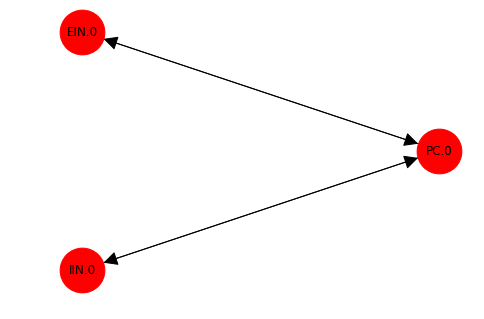

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
pos=nx.spring_layout(circuit.graph)
nx.draw_shell(circuit.graph, with_labels=True, node_size=2000, arrowsize=30)

Alternatively, PyRates provides a custom implementation using `pydot`:

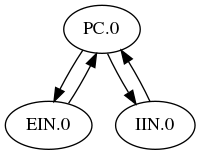

In [14]:
from pyrates.utility.visualization import plot_network_graph
plot_network_graph(circuit)

## Part 3: How do I run simulations on my network model?

### Setting up the backend

The *intermediate representation* is a user-friendly representation of a network model. Computations are realised via a *computation backend*. In the backend, the IR is restructured into what we call the `ComputeGraph`:

In [15]:
T = 10.0
dt = 0.001
from pyrates.backend import ComputeGraph
net = ComputeGraph(circuit, vectorization="nodes", dt=dt, build_in_place=False, 
                   backend="numpy", solver="midpoint")

vectorizing the graph nodes...
building the compute graph...
EXPERIMENTAL FEATURE WARNING: Using the midpoint method for solving differential equations is not fully tested yet and should be used with caution.


Here, the keyword argument `vectorization` is used to group identical nodes such that their equations can be calculated more efficiently. A such reorganised network consists of 2 instead of 3 nodes, because the EIN and IIN nodes actually contain the same equations:

In [16]:
net.net_config.nodes

NodeView(('PC_all.0', 'IIN_EIN_all.0'))

### Running simulations

Simulations are started using the `.run()` method of our `ComputeGraph`. Note that we are using an *input* variable `u` to pass external input for driving the circuit. The variable `u` is contained in the operator `RPO_e_pc.0` of our `PC` node:

In [17]:
import numpy as np
ext_input = np.random.uniform(120., 320., (int(T/dt), 1))
results = net.run(simulation_time = T, 
                  outputs={'V_PC': 'PC.0/OBS.0/V',
                           'V_EIN': 'EIN.0/RPO_e.0/PSP',
                           'V_IIN': 'IIN.0/RPO_e.0/PSP'}, 
                  inputs={'PC.0/RPO_e_pc.0/u': ext_input})

Preparing the simulation...
Running the simulation...
finished!


The `outputs` keyword is used to indicate which state variables to record during the simulation. In this case, we record the variable `PSP` of the operator `PRO.0` on node `PC` and name it `V`. 

The `inputs` argument, on the other hand, is used to apply externally defined input to certain variables in the network. In this example, input is provided to the variable `u` of operator `RPO_e_pc` on node `PC`. 

Note that input variables need to be defined for each simulation step (number of simulation steps = T/dt). For further keyword arguments that can be provided to the `run` method, please have a look at the methods' docstring. 

### Investigating the simulation results

The resulting timeseries are returned as a handy `pandas.DataFrame`:

In [18]:
results.head()

var,V_PC,V_EIN,V_IIN
node,PC.0/OBS.0,EIN.0/RPO_e.0,IIN.0/RPO_e.0
0.000,0.000000,0.000000,0.000000e+00
0.001,0.000000,0.000000,0.000000e+00
0.002,0.000000,0.000004,9.205311e-07
0.003,0.000067,0.000013,3.345460e-06
0.004,0.000178,0.000028,7.070024e-06


For visualization, processing and analysis of those timeseries, PyRates provides a variety of wrappers to other open-source Python tools such as `seaborn` and `MNE Python` (accesible via the `pyrates.utility` module). Some of the available post-processing/visualization methods are used as follows: 

#### Visualization of the raw timeseries

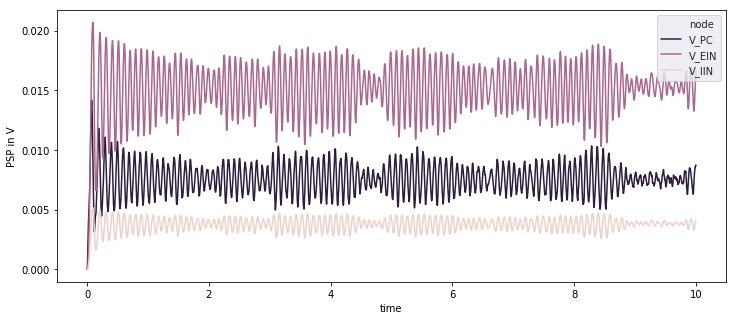

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(12, 5))

from pyrates.utility import plot_timeseries
plot_timeseries(results, ax=axes, ylabel='PSP in V')

#### Visualization of pair-wise correlations of the node's firing rates

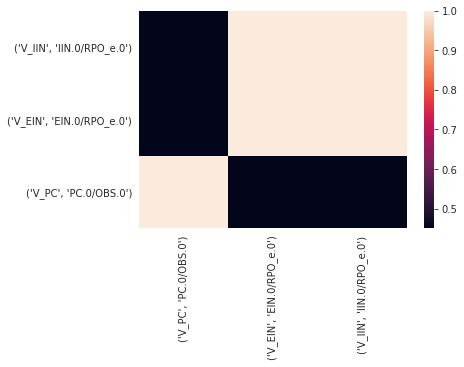

In [20]:
# calculation of the pair-wise correlations of the raw signals of each node
from pyrates.utility import functional_connectivity
fc = functional_connectivity(results, metric='corr')

# plotting of the correlation matrix
from pyrates.utility import plot_connectivity
nodes = results.columns.values
plot_connectivity(fc, yticklabels=nodes, xticklabels=nodes)

#### Visualization of the power-spectral densities of the node's firing rates

Creating RawArray with float64 data, n_channels=3, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
Effective window size : 2.048 (s)


/home/rgast/PycharmProjects/PyRates/pyrates/utility/mne_wrapper.py:123: RuntimeWarning: 3 channel names are too long, have been truncated to 15 characters:
["('V_PC', 'PC.0/OBS.0')", "('V_EIN', 'EIN.0/RPO_e.0')", "('V_IIN', 'IIN.0/RPO_e.0')"]
  info = mne.create_info(ch_names=ch_names_str, ch_types=ch_types, sfreq=1/dt)
/home/rgast/PycharmProjects/PyRates/pyrates/utility/visualization.py:526: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  return plot_raw_psd(raw, tmin=tmin, fmin=fmin, fmax=fmax, **kwargs).axes


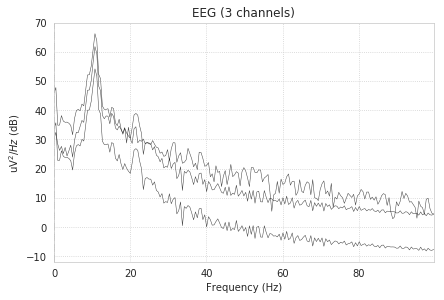

In [21]:
from pyrates.utility import plot_psd
plot_psd(results)

## Part 4: How do I run parameter studies on my model?

PyRates also provides functionalities to perform parameter sweeps over high-dimensional model parameter spaces. These functionalities are found in the `utilities` module. They allow to perform multi-dimensional parameter sweeps on single machines using the `grid_search()` function and on compute clusters using the `ClusterGridsearch` class. In the following, we will use `grid_search()` for a simple investigation of how the Jansen-Rit model behavior changes when its connection weights are scaled up or down. 

In [22]:
from pyrates.utility import grid_search

# generate 5 sets of differently scaled connection strengths
C = [68., 128., 135., 270., 675., 1350.]
pc_ein, ein_pc, pc_iin, iin_pc = [], [], [], []
for c in C:
    pc_ein.append(c)
    ein_pc.append(0.8*c)
    pc_iin.append(0.25*c)
    iin_pc.append(0.25*c)

# perform parameter study
results = grid_search("model_templates.jansen_rit.simple_jansenrit.JRC", 
                      param_grid={'PC_EIN': pc_ein, 
                                  'EIN_PC': ein_pc, 
                                  'PC_IIN': pc_iin,
                                  'IIN_PC': iin_pc},
                      param_map={'PC_EIN': {'vars': ['weight'],
                                            'edges': [('PC.0', 'EIN.0', 0)]},
                                 'EIN_PC': {'vars': ['weight'],
                                            'edges': [('EIN.0', 'PC.0', 0)]},
                                 'PC_IIN': {'vars': ['weight'],
                                            'edges': [('PC.0', 'IIN.0', 0)]},
                                 'IIN_PC': {'vars': ['weight'],
                                            'edges': [('IIN.0', 'PC.0', 0)]}},
                     permute_grid=False,
                     simulation_time=T, dt=dt,
                     sampling_step_size=1e-3, 
                     inputs={'PC/RPO_e_pc.0/u': ext_input},
                     outputs={'V': 'PC.0/OBS.0/V'},
                     init_kwargs={'vectorization': 'nodes'})

vectorizing the graph nodes...
building the compute graph...
Preparing the simulation...
Running the simulation...


/home/rgast/PycharmProjects/PyRates/documentation/CNS_2019_Tutorial/pyrates_build/net0/layer_0/op_0.py:4: RuntimeWarning: overflow encountered in exp
  m_out_16[:] = np.divide(c_219,np.add(c_218,np.exp(np.multiply(c_217,np.subtract(c_216,np.sum((PSP_23,PSP_1_10,),c_215))))))


finished!


In the above cell, we performed a grid search on the JRC defined in the YAML file we provided the path to via the first argument. Alternatively, we could have passed a `CircuitTemplate` instance here.

We told `grid_search` via the `param_grid` argument to sweep over 6 different weights for each of the 4 edges in our circuit (PC $\rightarrow$ EIN, PC $\rightarrow$ IIN, EIN $\rightarrow$ PC and IIN $\rightarrow$ PC). 

We further provided a pointer to the respective edge attributes of our JRC with `param_map`. Specifically, we provided a `dict` for each key in `param_grid` containing the names of all edge attributes that should take on the sweep values and the identifiers of the edges that should be included in the sweep.

If we would like `grid_search` to go through all possible combinations of the edge scalings (i.e. 4x6), we would need to set `permute_grid` to `True`. With `permute_grid` set to `False`, we will get the results of 6 different parametrizations of the JRC instead (i.e. `grid_search`  loops simultaneously over the positions in the parameter sweeps).

All other arguments to `grid_search` are passed on to the `run` method of the `ComputeGraph`, except for `init_kwargs` which contains all keyword arguments for the initialization of the `ComputeGraph`.

For visualization of the time series, we use a wrapper to `seaborn`.

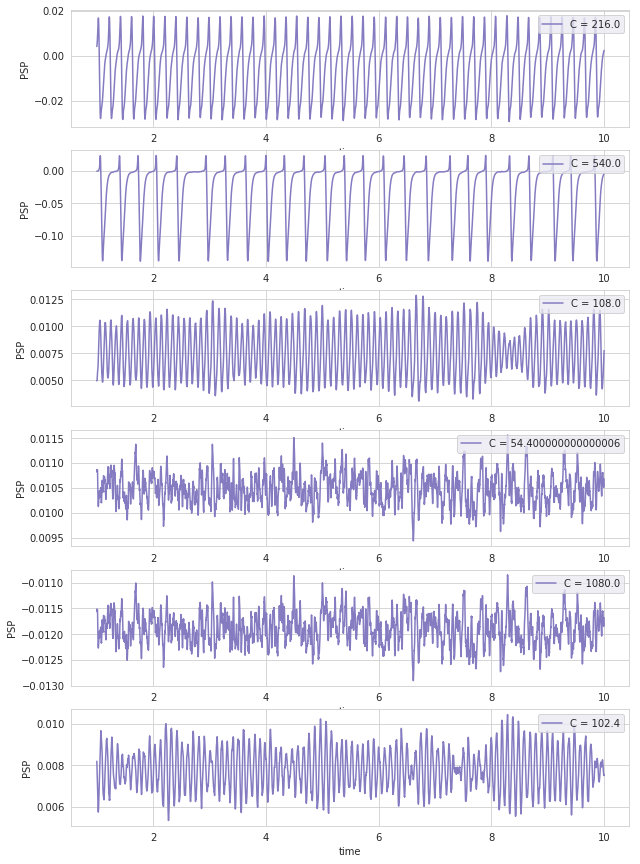

In [23]:
from pyrates.utility import create_cmap, plot_timeseries
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(C), figsize=(10, 15))

# create the color map
cmap = create_cmap('pyrates_purple', as_cmap=False, n_colors=1, reverse=True)

# plot the raw output variable for each condition
for i, ax in enumerate(axes):
    plot_timeseries(results.iloc[results.index > 1.0, i], ax=ax, cmap=cmap, 
                    ylabel='PSP')
    ax.legend([f'C = {results.columns.values[i][1]}'], loc='upper right')

You can compare the outputs of `grid_search` to the simulation results reported in Jansen & Rit (1995, Biological Cybernetics). They investigated exactly the same parameter range and produced a figure pretty much like the one above.

## Part 5: How do I create models without YAML templates?

Building models in the above described way has three advantages:
1. the model definition requires a minimum of syntax
2. defining a model via YAML templates means setting up an independent, reusable model configuration file (the .yml file) of small size that can easily be stored, shared and read without any python knowledge
3. Each YAML template of a PyRates model structure can be reused as a base template for a new YAML template

However, if you know your way around Python and you prefer to set up your full workflow (from model definition to simulation) in Python, this is also possible in PyRates. 

### Defining an Operator template

To define an operator template from within Python, we will make use of the `OperatorTemplate` class again. However, instead of using the `from_yaml` method, we will simply instantiate it with the respective arguments:

In [24]:
from pyrates.frontend import OperatorTemplate
pro = OperatorTemplate(name='PRO', path=None, 
                       equations=["m_out = 2.*m_max / (1 + exp(r*(V_th - V)))"], 
                       variables={'m_out': {'default': 'output'},
                                  'V': {'default': 'input'},
                                  'V_thr': {'default': 6e-3},
                                  'm_max': {'default': 2.5},
                                  'r': {'default': 560.0}
                                  },
                       description="")
pro.variables

{'m_out': {'default': 'output'},
 'V': {'default': 'input'},
 'V_thr': {'default': 0.006},
 'm_max': {'default': 2.5},
 'r': {'default': 560.0}}

In this case, we need the keyword arguments `equations` and `variables` to set up an operator (which is identical for the YAML operator template). As a general rule, every argument that is followed by a list of `- <value>`  entries in the YAML template also requires a Python list to be passed in the Python call (as for the `equations` argument above). Similarly, every argument that is followed by a list of `<key>: <value>`entries in the YAML template, requires a Python dictionary to be passed in the Python call (as for the `variables` argument above).

### Defining Node and Circuit templates in pure Python

We will skip defining the `RPO` operators, simply load them from YAML and jump ahead to a demonstration on how to create an operator and a circuit template without YAML.

In [25]:
rpo_e_pc = OperatorTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.RPO_e_pc")
rpo_i = OperatorTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.RPO_i")

#### Node template

We will use the example of the pyramidal cell node template. Again, we make use of the `NodeTemplate` class to set it up and provide the same arguments as for the YAML node template:

In [26]:
pc2 = NodeTemplate(name="PC", path=None, operators=[pro, rpo_e_pc, rpo_i])
pc2

<NodeTemplate 'None'>

If you would like to change a default value on one of the operators, this would be possible by using a `dict` instead of a `list` for the `operators` keyword argument:

In [27]:
pc3 = NodeTemplate(name="PC", path=None, 
                   operators={pro: {'r': 400.0}, rpo_e_pc: {}, rpo_i: {}})
pc3

<NodeTemplate 'None'>

Since the definition of the other two populations will follow the same structure, we will skip that here and simply load them from YAML.

In [28]:
ein = NodeTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.EIN")
iin = NodeTemplate.from_yaml("model_templates.jansen_rit.simple_jansenrit.IIN")

#### Circuit template

Finally, to build a circuit without a YAML tempplate, use the `CircuitTemplate` class the following:

In [29]:
circuit2 = CircuitTemplate(name="JRC", nodes={'PC': pc2, 'EIN': ein, 'IIN': iin},
                           edges=[["PC/PRO/m_out", "IIN/RPO_e/m_in", None, {'weight': 33.75}],
                                  ["PC/PRO/m_out", "EIN/RPO_e/m_in", None, {'weight': 135.}],
                                  ["EIN/PRO/m_out", "PC/RPO_e_pc/m_in", None, {'weight': 108.}],
                                  ["IIN/PRO/m_out", "PC/RPO_i/m_in", None, {'weight': 33.75}]
                                 ],
                           path=None
                          )
circuit2.nodes

{'PC': <NodeTemplate 'None'>,
 'EIN': <NodeTemplate 'model_templates.jansen_rit.simple_jansenrit.EIN'>,
 'IIN': <NodeTemplate 'model_templates.jansen_rit.simple_jansenrit.IIN'>}

From here on, the circuit template can be used the same way, as a YAML-based circuit template to create an intermediate representation. To be precise, for every template type (operator, node, edge and circuit) identical versions can be created via YAML or Python. For later modeling steps (setting up the intermediate representation, simulating the model behavior, ...), they are completely exchangeable.